In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import scipy

from statsmodels.formula.api import ols

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, clear_output

%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, NMF, TruncatedSVD

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.ensemble import ExtraTreesClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [3]:
from libscores import bac_metric

In [4]:
def read_info(file_name):
    result = []
    
    for line in file(file_name):
        key, value = line.strip().split('=')
        key = key.strip()
        value = value.strip().strip("'")
        if value.isdigit():
            value = int(value)
        result.append((key, value))
    
    return dict(result)

In [5]:
public = read_info('data/set3_helena/helena_public.info')
public

{'feat_num': 27,
 'feat_type': 'Numerical',
 'has_categorical': 0,
 'has_missing': 0,
 'is_sparse': 0,
 'label_num': 100,
 'metric': 'bac_metric',
 'name': 'helena',
 'target_num': 100,
 'target_type': 'Categorical',
 'task': 'multiclass.classification',
 'test_num': 18628,
 'time_budget': 1200,
 'train_num': 65196,
 'usage': 'AutoML challenge 2014',
 'valid_num': 9314}

In [6]:
def read_float_dense_features(file_name):
    result = list()
    for line in file(file_name):
        row = [float(f) for f in line.strip().split(' ')]
        result.append(row)
    return np.array(result)

In [7]:
def read_multilabels(file_name):
    result = list()
    for line in file(file_name):
        row = [f for f in line.strip().split(' ')]
        result.append(row.index('1'))
    return np.array(result)

In [8]:
X = read_float_dense_features('data/set3_helena/helena_train.data')
y = read_multilabels('data/set3_helena/helena_train.solution')

X_valid = read_float_dense_features('data/set3_helena/helena_valid.data')
X_test  = read_float_dense_features('data/set3_helena/helena_test.data')

print X.shape, y.shape, np.unique(y).shape
print X_valid.shape, X_test.shape

(65196, 27) (65196,) (100,)
(9314, 27) (18628, 27)


In [9]:
classes = np.unique(y)

In [10]:
scaler = StandardScaler(with_mean=True, copy=False)
X = scaler.fit_transform(X)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

Learning curves

In [35]:
n_iter = 5
cv = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=0.25, random_state=1)

scores = []
it = 1
for train, test in cv:
    print 'iteration %d' % it

    model = LogisticRegression(n_jobs=-1)
    
    X_train = X[train]
    y_train = y[train]
    N, d = X_train.shape

    sample_size = list(range(5000, N, 5000)) + [N]
    for j in tqdm(sample_size):
        model.fit(X_train[:j], y_train[:j])
        y_pred = model.predict_proba(X[test])

        score = bac_metric(label_binarize(y[test], classes=classes), y_pred)
        scores.append((it, j, score))

    it = it + 1
clear_output()

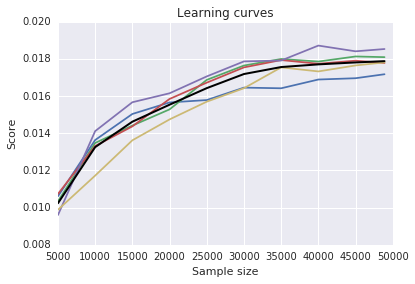

In [36]:
learning = pd.DataFrame(scores, columns=['it', 'sample_size', 'score'])

for it, grp in learning.groupby('it'):
    plt.plot(grp.sample_size, grp.score)

mean_score = learning.groupby('sample_size').score.mean()
plt.plot(mean_score.index, mean_score.values, color='black', linewidth=2)

plt.title('Learning curves')
plt.xlabel('Sample size')
plt.ylabel('Score')

plt.show()

In [11]:
X_input = X

In [12]:
results = []

In [17]:
models = {
    'logreg': LogisticRegression(),
}

params = {
    'cv_train_size': 0.80,
    'model': 'logreg'
}

pipeline = Pipeline([
    ('model', models[params['model']])
])

pipe_params = {
    'model__penalty': 'l2',
    'model__C': 1000,
}
pipeline.set_params(**pipe_params)

n_iter = 5
cv = StratifiedShuffleSplit(y, n_iter=n_iter, train_size=params['cv_train_size'], random_state=1)

scores = []
for train, test in tqdm(cv):
    pipeline.fit(X_input[train], y[train])
    
    y_pred = pipeline.predict_proba(X_input[test])
    y_test = label_binarize(y[test], classes=classes)
    score = bac_metric(y_test, y_pred, task='multiclass.classification')
    scores.append(score)

params.update(pipe_params)
results.append((params, np.mean(score), np.std(score)))
print np.mean(score), np.std(score)

0.133877656806 0.0


In [18]:
for p, s, std in reversed(results[-5:]):
    print u'score: %0.5f ± %0.5f, params: %s' % (s, std, p)

score: 0.13388 ± 0.00000, params: {'model__C': 1000, 'model': 'logreg', 'model__penalty': 'l2', 'cv_train_size': 0.8}
score: 0.12734 ± 0.00000, params: {'model__C': 1000, 'model': 'logreg', 'model__penalty': 'l2', 'cv_train_size': 8000}
score: 0.12710 ± 0.00000, params: {'model__C': 10000, 'model': 'logreg', 'model__penalty': 'l2', 'cv_train_size': 8000}


In [19]:
pipeline.fit(X, y)

Pipeline(steps=[('model', LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [46]:
y_valid_score = pipeline.predict_proba(X_valid)[:, 1]
y_test_score = pipeline.predict_proba(X_test)[:, 1]


In [48]:
np.savetxt('submission/helena_valid.predict', y_valid_score, fmt='%0.18f')
np.savetxt('submission/helena_test.predict', y_test_score, fmt='%0.18f')